## Mini Project III

In [1]:
from EDA_snippets import *
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, quantile_transform
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

from plotly import graph_objects as go

In [2]:
customers = pd.read_csv('data/twm_customer.csv', delimiter=';')
transactions = pd.read_csv('data/twm_transactions.csv', delimiter=';')
accounts = pd.read_csv('data/twm_accounts.csv', delimiter=';')

### Customers

#### Prep

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   cust_id          747 non-null    int64 
 1   income           747 non-null    int64 
 2   age              747 non-null    int64 
 3   years_with_bank  747 non-null    int64 
 4   nbr_children     747 non-null    int64 
 5   gender           747 non-null    object
 6   marital_status   747 non-null    int64 
 7   name_prefix      747 non-null    object
 8   first_name       747 non-null    object
 9   last_name        747 non-null    object
 10  street_nbr       747 non-null    int64 
 11  street_name      747 non-null    object
 12  postal_code      747 non-null    int64 
 13  city_name        747 non-null    object
 14  state_code       747 non-null    object
dtypes: int64(8), object(7)
memory usage: 87.7+ KB


In [4]:
customers.head(10)
# zip codes? for location proximity information
# gender encoded in one column 0/1
# nbr/children maybe bin or reduce to have/not
# age can be binned as well (or polynomial transformation)
# marital status? dummy variables instead of ordinal

cust_id  income  age  years_with_bank  nbr_children gender  marital_status  \
0  1362691   26150   46                5             1     M                2   
1  1362487    6605   71                1             0     M                2   
2  1363160   18548   38                8             0     F                1   
3  1362752   47668   54                3             0     F                1   
4  1362548   44554   59                9             2     F                4   
5  1362813   15684   53                3             2     F                2   
6  1363017       0   16                1             0     M                1   
7  1362609    1929   79                8             0     F                2   
8  1363486   39942   41                1             5     F                4   
9  1363078    9622   46                6             1     M                2   

  name_prefix                                         first_name  \
0              Donald                                        ...   
1              ChingDyi                                      ...   
2              Rosa                                          ...   
3              Lisa                                          ...   
4              Barbara                                       ...   
5              Terry                                         ...   
6              Tim                                           ...   
7              Sandy                                         ...   
8              Jill                                          ...   
9    Mr.       Christopher                                   ...   

                                           last_name  street_nbr  \
0  Marek                                         ...        8298   
1  Moussavi                                      ...       10603   
2  Johnston                                      ...        8817   
3  Martin                                        ...         676   
4  O'Malley                                      ...        6578   
5  Eubanks                                       ...        6999   
6  McMillen                                      ...       10274   
7  Rayhanian                                     ...        6168   
8  Campbell                                      ...        3830   
9  McVicker                                      ...       14382   

                                         street_name  postal_code  \
0  Second                                        ...        89194   
1  Daffodil                                      ...        90159   
2  Figueroa                                      ...        90024   
3  Humble                                        ...        90172   
4  C                                             ...        10138   
5  Begonia                                       ...        60654   
6  Mission Gorge                                 ...        90095   
7  Camellia                                      ...        96846   
8  Tenth                                         ...        96802   
9  Peach                                         ...        96822   

                                  city_name state_code  
0  Las Vegas                                      NV    
1  Los Angeles                                    CA    
2  Los Angeles                                    CA    
3  Los Angeles                                    CA    
4  New York City                                  NY    
5  Chicago                                        IL    
6  Los Angeles                                    CA    
7  Honolulu                                       HI    
8  Honolulu                                       HI    
9  Honolulu                                       HI

In [5]:
customers.cust_id.nunique() == customers.shape[0]

True

#### Data cleaning

In [6]:
customers.state_code.nunique()

33

In [7]:
regions = ['W', 'MW', 'S', 'NE']

state_to_region = {
    'NV': 'W',
    'CA': 'W',
    'NY': 'NE',
    'IL': 'MW',
    'HI': 'W',
    'DC': 'S',
    'TX': 'S',
    'PA': 'NE',
    'OR': 'W',
    'OH': 'MW',
    'WA': 'W',
    'NJ': 'NE',
    'IN': 'MW',
    'CO': 'W',
    'WI': 'MW',
    'MI': 'MW',
    'NB': 'MW',
    'AZ': 'W',
    'MN': 'MW',
    'TN': 'S',
    'VA': 'S',
    'FL': 'S',
    'MD': 'S',
    'MO': 'W',
    'LA': 'S',
    'KY': 'S',
    'OK': 'S',
    'MA': 'NE',
    'GA': 'S',
    'KS': 'MW',
    'NC': 'S',
    'NM': 'W',
    'AL': 'S'
}

In [8]:
customers['region'] = customers['state_code'].apply(lambda x: state_to_region[x.strip()])

In [9]:
# convert gender to binary with 0=M and 1=F
customers['gender'] = customers['gender'].apply(lambda x: 0 if (x.strip().lower() == 'm') else 1)

In [10]:
customers['name_prefix'].value_counts()

            505
Ms.          92
Mr.          82
Mrs.         31
Dr.          22
Miss         15
Name: name_prefix, dtype: int64

In [11]:
customers['nbr_children'].value_counts()

0    466
1    114
2    110
3     38
5     10
4      9
Name: nbr_children, dtype: int64

<AxesSubplot:xlabel='nbr_children', ylabel='income'>

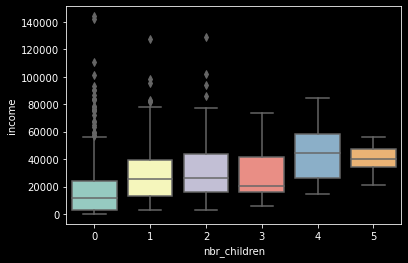

In [12]:
sns.boxplot(x=customers.nbr_children, y=customers.income)

In [13]:
kids = customers.nbr_children.apply(lambda x: 1 if (x >= 1) else 0)

<AxesSubplot:xlabel='nbr_children', ylabel='income'>

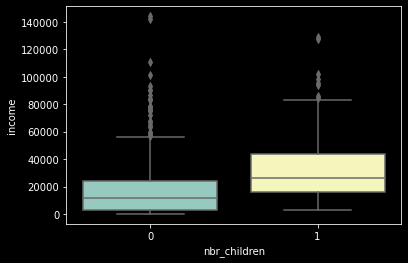

In [14]:
sns.boxplot(x=kids, y=customers.income)

In [15]:
customers['has_children'] = kids

<AxesSubplot:xlabel='marital_status', ylabel='income'>

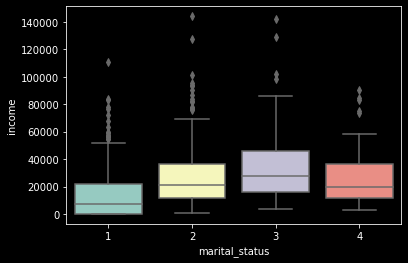

In [16]:
sns.boxplot(x=customers.marital_status, y=customers.income)

1 = single
2 = married
3/4 widowed/divorced?

In [17]:
customers.describe()

cust_id         income         age  years_with_bank  nbr_children  \
count  7.470000e+02     747.000000  747.000000       747.000000    747.000000   
mean   1.362991e+06   22728.281124   42.479250         3.907631      0.714859   
std    2.925255e+02   22207.221405   19.114879         2.675634      1.103410   
min    1.362480e+06       0.000000   13.000000         0.000000      0.000000   
25%    1.362732e+06    7118.500000   28.000000         2.000000      0.000000   
50%    1.362993e+06   17242.000000   42.000000         4.000000      0.000000   
75%    1.363244e+06   31338.000000   56.000000         6.000000      1.000000   
max    1.363495e+06  144157.000000   89.000000         9.000000      5.000000   

           gender  marital_status    street_nbr   postal_code  has_children  
count  747.000000      747.000000    747.000000    747.000000    747.000000  
mean     0.559572        1.882195   8523.109772  59502.690763      0.376171  
std      0.496771        0.892051   5219.488263  31205.926508      0.484748  
min      0.000000        1.000000    196.000000   2149.000000      0.000000  
25%      0.000000        1.000000   4295.500000  33145.000000      0.000000  
50%      1.000000        2.000000   8001.000000  64132.000000      0.000000  
75%      1.000000        2.000000  12039.000000  90082.000000      1.000000  
max      1.000000        4.000000  19940.000000  98186.000000      1.000000

In [18]:
customers = customers.drop(columns=['name_prefix', 'first_name', 'last_name', 'postal_code', 'city_name', 'state_code', 'nbr_children', 'street_name', 'street_nbr'])
customers.head()

cust_id  income  age  years_with_bank  gender  marital_status region  \
0  1362691   26150   46                5       0               2      W   
1  1362487    6605   71                1       0               2      W   
2  1363160   18548   38                8       1               1      W   
3  1362752   47668   54                3       1               1      W   
4  1362548   44554   59                9       1               4     NE   

   has_children  
0             1  
1             0  
2             0  
3             0  
4             1

<AxesSubplot:xlabel='region', ylabel='income'>

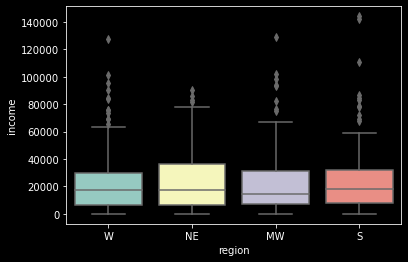

In [19]:
sns.boxplot(x=customers.region, y=customers.income)

In [20]:
regions = pd.get_dummies(customers['region'], drop_first=True)

In [21]:
type(regions)

pandas.core.frame.DataFrame

In [22]:
regions.head()

NE  S  W
0   0  0  1
1   0  0  1
2   0  0  1
3   0  0  1
4   1  0  0

In [23]:
regions.columns

Index(['NE', 'S', 'W'], dtype='object')

In [24]:
regions

NE  S  W
0     0  0  1
1     0  0  1
2     0  0  1
3     0  0  1
4     1  0  0
..   .. .. ..
742   0  0  1
743   1  0  0
744   0  0  1
745   0  1  0
746   0  0  1

[747 rows x 3 columns]

In [25]:
customers[regions.columns] = regions

In [26]:
customers = customers.drop(columns=['region'])

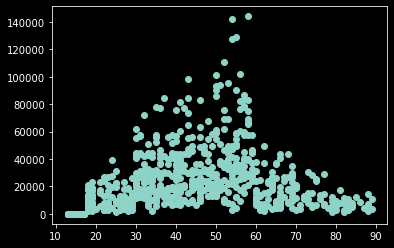

In [27]:
plt.scatter(x=customers.age, y=customers.income)

In [28]:
# All ages < 18 have no income
customers[customers['income'] == 0]['age'].value_counts()

15    32
17    21
16    19
13    15
14    15
Name: age, dtype: int64

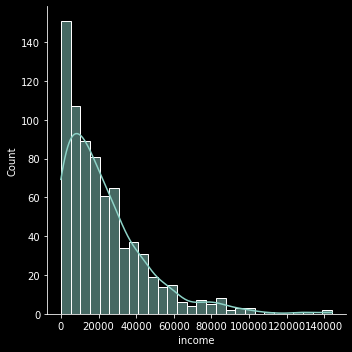

In [29]:
sns.displot(customers['income'], kde=True)

M:\Anaconda\envs\LHL\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


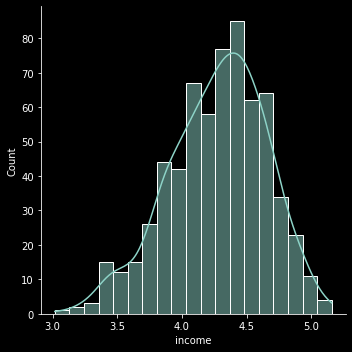

In [30]:
sns.displot(np.log10(customers['income']), kde=True)

#### Data transformation

In [31]:
# impute median income for young teens
# customers['income'] = customers['income'].apply(lambda x: customers['income'].median() if (x == 0) else x)

In [32]:
customers['log10_income'] = np.log10(customers.income)

M:\Anaconda\envs\LHL\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
customers['log10_income'].value_counts()

-inf         102
 4.098990      2
 3.905148      2
 4.081779      2
 4.386820      2
            ... 
 4.559152      1
 4.695683      1
 5.111249      1
 4.598823      1
 4.252246      1
Name: log10_income, Length: 640, dtype: int64

In [34]:
row_selector = np.isneginf(customers['log10_income']) # setup row selection to replace -inf with 0.
customers.loc[row_selector, 'log10_income'] = 0

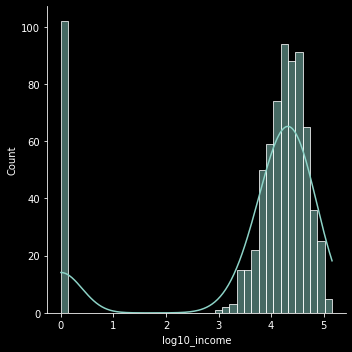

In [35]:
sns.displot(customers['log10_income'], kde=True)

In [36]:
customers[customers.income == 0].income.value_counts() / customers.shape[0]

0    0.136546
Name: income, dtype: float64

In [37]:
customers.head()

cust_id  income  age  years_with_bank  gender  marital_status  \
0  1362691   26150   46                5       0               2   
1  1362487    6605   71                1       0               2   
2  1363160   18548   38                8       1               1   
3  1362752   47668   54                3       1               1   
4  1362548   44554   59                9       1               4   

   has_children  NE  S  W  log10_income  
0             1   0  0  1      4.417472  
1             0   0  0  1      3.819873  
2             0   0  0  1      4.268297  
3             0   0  0  1      4.678227  
4             1   1  0  0      4.648887

(747, 11)

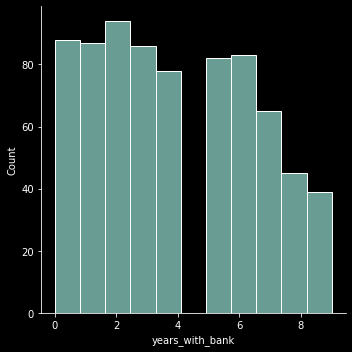

In [38]:
sns.displot(customers['years_with_bank'])
customers.shape

In [39]:
customers.age.describe()

count    747.000000
mean      42.479250
std       19.114879
min       13.000000
25%       28.000000
50%       42.000000
75%       56.000000
max       89.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='Count'>

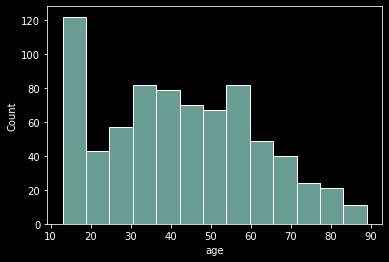

In [40]:
sns.histplot(customers.age)

In [41]:
poly_test = customers.copy() # copy a frame to use in the poly section.

ages  
13-17  
18-25  
25-30 NOTE  
30-40  
40-50  
50-60  
60-75  
75+  

In [42]:
model_customers = customers.drop(columns=['cust_id', 'income'])
quantile_test = model_customers.copy()

#### Quantile Rank Normalization

In [43]:
normalized_observations = quantile_transform(quantile_test[['age', 'years_with_bank', 'log10_income']],
                                             n_quantiles=75,
                                             output_distribution='normal')

In [44]:
normalized_observations

array([[ 0.17018472,  0.32756149,  0.42043618],
       [ 1.42848207, -0.93197131, -0.71022025],
       [-0.17018472,  1.39783653,  0.07715672],
       ...,
       [ 0.34548507, -5.19933758,  1.56504432],
       [-0.21641028,  1.01352217, -0.10859268],
       [-1.01352217, -0.20465992,  0.03372296]])

In [45]:
quantile_test[['age', 'years_with_bank', 'log10_income']] = normalized_observations
quantile_test.head()

age  years_with_bank  gender  marital_status  has_children  NE  S  W  \
0  0.170185         0.327561       0               2             1   0  0  1   
1  1.428482        -0.931971       0               2             0   0  0  1   
2 -0.170185         1.397837       1               1             0   0  0  1   
3  0.532190        -0.204660       1               1             0   0  0  1   
4  0.832006         5.199338       1               4             1   1  0  0   

   log10_income  
0      0.420436  
1     -0.710220  
2      0.077157  
3      1.202177  
4      1.113112

#### Standard Scaling

In [46]:
std_scalar = StandardScaler()
scaled_customers = std_scalar.fit_transform(model_customers)
scaled_quantiles = std_scalar.fit_transform(quantile_test)

In [47]:
std_customers = pd.DataFrame(scaled_customers, columns=model_customers.columns)
std_quantiles = pd.DataFrame(scaled_quantiles, columns=quantile_test.columns)

In [48]:
std_customers.head()

age  years_with_bank    gender  marital_status  has_children       NE  \
0  0.184312         0.408539 -1.127172        0.132149      1.287774 -0.49707   
1  1.493070        -1.087435 -1.127172        0.132149     -0.776534 -0.49707   
2 -0.234490         1.530520  0.887176       -0.989614     -0.776534 -0.49707   
3  0.603115        -0.339448  0.887176       -0.989614     -0.776534 -0.49707   
4  0.864867         1.904514  0.887176        2.375675      1.287774  2.01179   

          S         W  log10_income  
0 -0.569621  1.298865      0.480869  
1 -0.569621  1.298865      0.084871  
2 -0.569621  1.298865      0.382019  
3 -0.569621  1.298865      0.653658  
4 -0.569621 -0.769903      0.634216

In [49]:
std_quantiles.head()

age  years_with_bank    gender  marital_status  has_children       NE  \
0  0.181310         0.259610 -1.127172        0.132149      1.287774 -0.49707   
1  1.219756        -0.306787 -1.127172        0.132149     -0.776534 -0.49707   
2 -0.099589         0.740899  0.887176       -0.989614     -0.776534 -0.49707   
3  0.480065         0.020276  0.887176       -0.989614     -0.776534 -0.49707   
4  0.727497         2.450387  0.887176        2.375675      1.287774  2.01179   

          S         W  log10_income  
0 -0.569621  1.298865      0.448909  
1 -0.569621  1.298865     -0.109650  
2 -0.569621  1.298865      0.279324  
3 -0.569621  1.298865      0.835100  
4 -0.569621 -0.769903      0.791100

In [50]:
# test_std = std_customers.drop(columns=['NE', 'S', 'W'])

In [51]:
# Testing without location data.
# test_std.head()

#### PCA

In [52]:
pca_transform = PCA(n_components=9)
pca_customers = pca_transform.fit_transform(std_customers)

In [53]:
quantiles_pca_transform = PCA(n_components=2)
pca_quantiles = quantiles_pca_transform.fit_transform(std_quantiles)

In [54]:
# test_transform = PCA(n_components=2)
# pca_test = test_transform.fit_transform(test_std)

In [55]:
pca_df = pd.DataFrame(pca_customers, columns=[f'PC{integer}'
                                              for integer in range(1, len(std_customers.columns)+1)])
quantiles_pca_df = pd.DataFrame(pca_quantiles, columns=['PC1', 'PC2'])

In [56]:
pca_df.shape

(747, 9)

In [57]:
quantiles_pca_df.head()

PC1       PC2
0 -0.859727  1.573032
1 -0.121732  0.969372
2  0.875901  1.113309
3  0.319683  1.028597
4 -2.671771 -0.359303

Text(0, 0.5, '(16.65% Variation Explained)\nPC2')

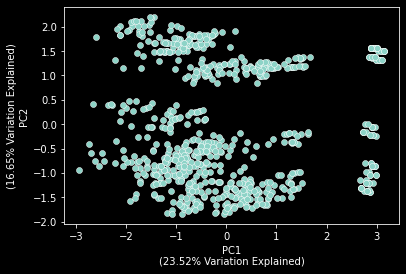

In [58]:
sns.scatterplot(x=pca_df.PC1, y=pca_df.PC2)
plt.xlabel(f'PC1\n({pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')

Text(0, 0.5, 'Variation Explained')

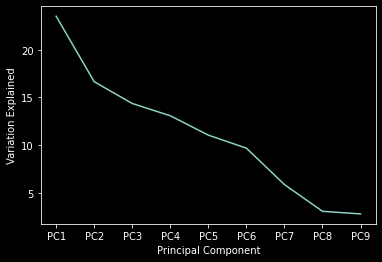

In [59]:
sns.lineplot(x=pca_df.columns, 
             y=(pca_transform.explained_variance_ratio_ * 100))

plt.xlabel('Principal Component')
plt.ylabel('Variation Explained')

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

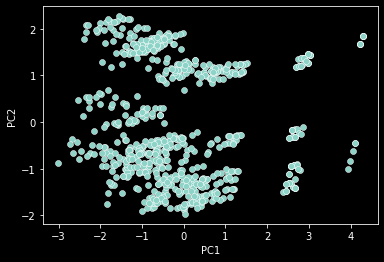

In [60]:
sns.scatterplot(x=quantiles_pca_df.PC1, y=quantiles_pca_df.PC2)

In [61]:
quantiles_pca_transform.explained_variance_ratio_

array([0.23936571, 0.16711622])

In [62]:
# sns.scatterplot(x=pca_test[:, 0], y=pca_test[:, 1])

#### Clustering (PCA results)

##### k-means

M:\Anaconda\envs\LHL\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


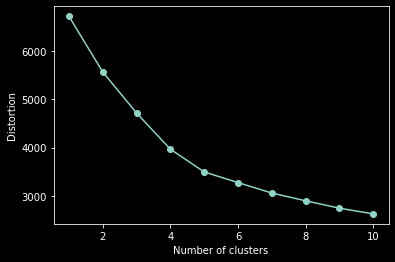

In [63]:
# Elbow rule suggests 3 clusters.

def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

plot_distortion(pca_customers, max_clusters=10)

In [64]:
kmeans = KMeans(n_clusters=5,
                n_init=50)

In [65]:
y_kmeans = kmeans.fit_predict(pca_customers)

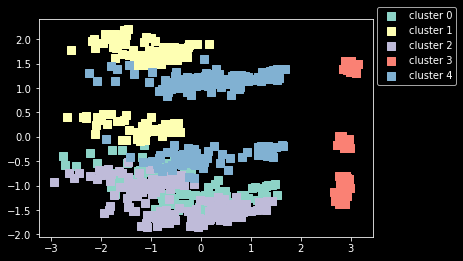

In [66]:
def plot_clusters(X, y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend(loc=(1.01, 0.7))
    plt.show()

plot_clusters(pca_customers, y_kmeans)

##### DBSCAN

In [67]:
cust_db = DBSCAN() # default params to start with

In [68]:
y_db = cust_db.fit_predict(pca_customers[:, 0:2])

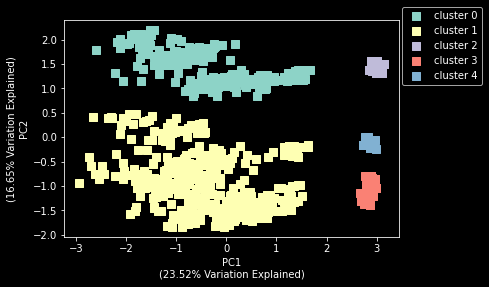

In [69]:
plt.xlabel(f'PC1\n({pca_transform.explained_variance_ratio_[0] * 100:.2f}% Variation Explained)')
plt.ylabel(f'({pca_transform.explained_variance_ratio_[1] * 100:.2f}% Variation Explained)\nPC2')
plot_clusters(pca_customers[:, 0:2], y_db)

#### Clustering (Standardized data)

M:\Anaconda\envs\LHL\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


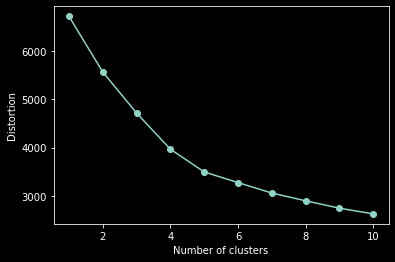

In [70]:
plot_distortion(std_customers, max_clusters=10)

In [71]:
std_customers_kmeans = KMeans(n_clusters=5,
                              n_init=100)

In [72]:
y_std_cust_kmeans = std_customers_kmeans.fit_predict(std_customers)

In [73]:
std_customers.head()

age  years_with_bank    gender  marital_status  has_children       NE  \
0  0.184312         0.408539 -1.127172        0.132149      1.287774 -0.49707   
1  1.493070        -1.087435 -1.127172        0.132149     -0.776534 -0.49707   
2 -0.234490         1.530520  0.887176       -0.989614     -0.776534 -0.49707   
3  0.603115        -0.339448  0.887176       -0.989614     -0.776534 -0.49707   
4  0.864867         1.904514  0.887176        2.375675      1.287774  2.01179   

          S         W  log10_income  
0 -0.569621  1.298865      0.480869  
1 -0.569621  1.298865      0.084871  
2 -0.569621  1.298865      0.382019  
3 -0.569621  1.298865      0.653658  
4 -0.569621 -0.769903      0.634216

In [74]:
df_scaled_customers_test = pd.read_csv('data/V1_std_customers.csv')

### Radar plots

In [75]:
def radar_plot_clusters(X, y_res):
    """
    Captures the mean and median for each feature seperately for each cluster and graphs a radar plot figure
    with 2 panels for each cluster (1 for mean and 1 for median).
    """
    figures = {} # key is plot name, value is pandas DataFrame.

    for cluster in set(y_res):
        _cluster_df = {}

        for column in X.columns:
            # These work because the row indices of y_res are expected to match those of X.
            _feature_mean_median = pd.Series({
                'mean': X.loc[y_res == cluster, column].mean(), 
                'median': X.loc[y_res == cluster, column].median()
            })

            _cluster_df[column] = _feature_mean_median
                
        figures[f'Cluster {cluster}'] = pd.DataFrame(_cluster_df)

    # print(figures['Cluster 1'].values)
    make_radar_plot_figures(figures)


In [76]:
def plot_radar_figure(title: str, figure: pd.DataFrame) -> None:

    fig = px.line_polar(data_frame = figure,
                        r=figure.values[1], 
                        theta=figure.columns, 
                        line_close=True, 
                        template='plotly_dark',
                        range_r=(-3,2),
                        title=title)
    fig.show()

In [77]:
def make_radar_plot_figures(figures: dict[pd.DataFrame]) -> None:
    for title, figure in figures.items():
        plot_radar_figure(title, figure)

In [78]:
radar_plot_clusters(std_customers, y_std_cust_kmeans)

In [79]:
radar_plot_clusters(std_customers, y_std_cust_kmeans)

In [80]:
# TODO integrate Jonas' code below

# categories = df_scaled_customers_test.iloc[:,:-1].columns

# def radar_plot(): 

#       fig = go.Figure()

#       fig.add_trace(go.Scatterpolar(
#             r=df_scaled_customers_test[df_scaled_customers_test['cluster'] == 0].iloc[:,:-1].median().values,
#             theta=df_scaled_customers_test.iloc[:,:-1].columns,
#             fill='toself',
#             fillcolor=None,
#             name='Cluster 0'
#       ))
#       fig.add_trace(go.Scatterpolar(
#             r=df_scaled_customers_test[df_scaled_customers_test['cluster'] == 1].iloc[:,:-1].median().values,
#             theta=df_scaled_customers_test.iloc[:,:-1].columns,
#             fill='toself',
#             name='Cluster 1'
#       ))
#       fig.add_trace(go.Scatterpolar(
#             r=df_scaled_customers_test[df_scaled_customers_test['cluster'] == 2].iloc[:,:-1].median().values,
#             theta=df_scaled_customers_test.iloc[:,:-1].columns,
#             fill='toself',
#             name='Cluster 2'
#       ))
#       fig.add_trace(go.Scatterpolar(
#             r=df_scaled_customers_test[df_scaled_customers_test['cluster'] == 3].iloc[:,:-1].median().values,
#             theta=df_scaled_customers_test.iloc[:,:-1].columns,
#             fill='toself',
#             name='Cluster 3'
#       ))
#       fig.add_trace(go.Scatterpolar(
#             r=df_scaled_customers_test[df_scaled_customers_test['cluster'] == 4].iloc[:,:-1].median().values,
#             theta=df_scaled_customers_test.iloc[:,:-1].columns,
#             fill='toself',
#             name='Cluster 4'
#       ))


#       fig.update_layout(
#       polar=dict(
#             radialaxis=dict(
#             visible=True,
#             range=[-3, 3]
#             )),
#       showlegend=True,
#       template='plotly_dark'
#       )

#       fig.show()

#### Poly exp on income and age

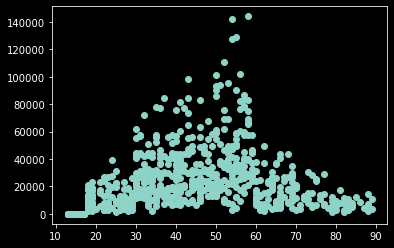

In [81]:
plt.scatter(x=customers.age, y=customers.income)

In [82]:
poly = PolynomialFeatures(2)

In [83]:
poly_income_age = poly.fit_transform(customers[['income', 'age']])

In [84]:
poly_income_age = pd.DataFrame(poly_income_age)

In [85]:
poly_income_age

0        1     2             3          4       5
0    1.0  26150.0  46.0  6.838225e+08  1202900.0  2116.0
1    1.0   6605.0  71.0  4.362602e+07   468955.0  5041.0
2    1.0  18548.0  38.0  3.440283e+08   704824.0  1444.0
3    1.0  47668.0  54.0  2.272238e+09  2574072.0  2916.0
4    1.0  44554.0  59.0  1.985059e+09  2628686.0  3481.0
..   ...      ...   ...           ...        ...     ...
742  1.0  14795.0  36.0  2.188920e+08   532620.0  1296.0
743  1.0  26387.0  56.0  6.962738e+08  1477672.0  3136.0
744  1.0  61300.0  50.0  3.757690e+09  3065000.0  2500.0
745  1.0  15100.0  37.0  2.280100e+08   558700.0  1369.0
746  1.0  17875.0  18.0  3.195156e+08   321750.0   324.0

[747 rows x 6 columns]

### Accounts

In [86]:
accounts.info()
# only end date has nulls, could add a category for closed/active = 0/1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acct_nbr          1409 non-null   int64  
 1   cust_id           1409 non-null   int64  
 2   acct_type         1409 non-null   object 
 3   account_active    1409 non-null   object 
 4   acct_start_date   1409 non-null   object 
 5   acct_end_date     143 non-null    object 
 6   starting_balance  1409 non-null   float64
 7   ending_balance    1409 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 88.2+ KB


In [87]:
accounts.head()

acct_nbr  cust_id acct_type account_active acct_start_date  \
0          13628063  1362806      SV               Y       10.12.1995   
1  4561143213627090  1362709      CC               Y        15.3.1993   
2  4561143213628360  1362836      CC               Y        18.3.1992   
3          13633112  1363311      CK               Y         6.7.1995   
4  4561143213633610  1363361      CC               Y        17.6.1994   

  acct_end_date  starting_balance  ending_balance  
0           NaN           1430.22          284.58  
1           NaN            266.34          496.15  
2           NaN             55.90         1000.00  
3           NaN          11017.13          968.46  
4           NaN            849.37          462.28

In [88]:
accounts['acct_type'].unique()

array(['SV  ', 'CC  ', 'CK  '], dtype=object)

### Transactions

In [89]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tran_id        77580 non-null  int64  
 1   acct_nbr       77580 non-null  int64  
 2   tran_amt       77580 non-null  float64
 3   principal_amt  77580 non-null  float64
 4   interest_amt   77580 non-null  float64
 5   new_balance    77580 non-null  float64
 6   tran_date      77580 non-null  object 
 7   tran_time      77580 non-null  int64  
 8   channel        77580 non-null  object 
 9   tran_code      77580 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 5.9+ MB


In [90]:
transactions.head(20)

tran_id          acct_nbr  tran_amt  principal_amt  interest_amt  \
0        27          13625623      0.00           0.00           0.0   
1        97          13628392      0.00           0.00           0.0   
2        21          13630842    -97.57         -97.57           0.0   
3        44          13631412     -0.15          -0.15           0.0   
4        31          13625722      0.00           0.00           0.0   
5        32          13625032     -0.15          -0.15           0.0   
6        60          13631642    -40.00         -40.00           0.0   
7        25  4561143213634590   -420.60        -420.60           0.0   
8         1          13631542      0.00           0.00           0.0   
9        19          13627532    -40.00         -40.00           0.0   
10       86          13629022      0.00           0.00           0.0   
11       45          13632573   -200.00        -200.00           0.0   
12       46          13634612      0.00           0.00           0.0   
13       58          13628552    -96.22         -96.22           0.0   
14       27          13630362    -14.01         -14.01           0.0   
15        4          13634532    -10.00         -10.00           0.0   
16       54  4561143213625470   -153.52        -153.52           0.0   
17       69  4561143213634000   -200.00        -200.00           0.0   
18       23          13628153   -129.92        -129.92           0.0   
19       25          13624922      5.40           0.00           5.4   

    new_balance   tran_date  tran_time channel tran_code  
0       3753.34  21.10.1995     121656      A       IQ    
1        254.49    5.2.1995     153053      V       IQ    
2       3819.56   23.7.1995          0      P       WD    
3        224.05   30.1.1995          0              FK    
4        240.55   25.1.1995     204521      B       IQ    
5       2064.28    3.4.1995          0              FK    
6        737.03   17.1.1995      83649      A       WD    
7      -2142.46  14.12.1995     110142      E       CG    
8        129.88    4.1.1995     100342      B       IQ    
9        173.09   17.5.1995     133522      A       WD    
10         3.73    8.4.1995     131316      A       IQ    
11       353.11   3.12.1995      90525      A       WD    
12      1928.39   24.3.1995     141229      K       IQ    
13        96.22    9.5.1995          0      P       WD    
14      2846.99   26.7.1995          0      P       WD    
15        67.15   31.1.1995     235959              FP    
16     -1354.47  10.11.1995     204225      E       CG    
17     -1912.60  30.10.1995     191749      A       CA    
18       576.09  12.12.1995     110610      B       WD    
19      4036.84   31.5.1995     235959              IN

In [91]:
transactions[transactions['tran_id'] == 123] # transcriptional error?

tran_id          acct_nbr  tran_amt  principal_amt  interest_amt  \
1854       123  4561143213632490   -180.00        -180.00           0.0   
37043      123  4561143213630020   -406.71        -406.71           0.0   
57594      123  4561143213627770   -176.72        -176.72           0.0   
60537      123  4561143213626830   -191.70        -191.70           0.0   

       new_balance   tran_date  tran_time channel tran_code  
1854      -2722.05   5.12.1995     162029      A       CA    
37043     -4359.11  14.10.1995     105753      E       CG    
57594     -1361.93  28.11.1995      82124      E       CG    
60537     -4902.99   2.12.1995     190502      E       CG